#### Traffic Sign Recognition Classifier

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [90]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn import preprocessing
import cv2
import random

from helpers import normalize_grayscale
from helpers import transform_image
from helpers import transform_image_data

from helpers import normal_equalize
from helpers import histogram_equalize_data
from plotters import plot_histograms

# Visualizations will be shown in the notebook.
%matplotlib inline



# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [91]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.

n_classes = len(np.unique(y_train))
test_classes = len(np.unique(y_test))
print('Train classes: {} Test classes: {}'.format(n_classes, n_test))
print('Training examples: {}, Testing examples: {}'.format(n_train, n_test))
print("Number of training examples =", n_train)
print('Number of training labels: (not unique): ',y_train.shape)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Train classes: 43 Test classes: 12630
Training examples: 39209, Testing examples: 12630
Number of training examples = 39209
Number of training labels: (not unique):  (39209,)
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Create validation set: 
#### X_train: 80% , X_validation: 20% (examples)
#### y_train: 80% , y_validation: 20% (labels)

In [92]:
# Create validation set:, likely using sklearn
import math
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = .80, test_size = 0.20)
training_percentage = X_train.shape[0] / n_train
num_training_examples = X_train.shape[0]
num_validation_examples = X_validation.shape[0]
assert(0.79 < training_percentage < 0.801)

# Read classes label data csv (signnames.csv)
### contains: index | classId | SignName
##### Example: 0    |   0    |    Speed limit (20km/h)

In [93]:
data_pd = pd.read_csv('signnames.csv')

data_i = [[class_number, sum(y_train == class_number)] for class_number in range(len(np.unique(y_train)))]
# Now we have a list with the indices of each class change in the y_train dataset
# data_i is an array of tuples (class_number, # of occurances)

# Now we wish to sort this list from most common occurances to least common occurances
data_i_sorted = sorted(data_i, key = lambda i: i[1])
data_i_sorted_array = np.array(data_i_sorted)

# Use occurance as [1] and index set to the indexes as .T[0]
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index = np.asarray(data_i_sorted).T[0])

# Include scaling factor
max_abundance = np.max(np.asarray(data_i_sorted).T[1])
scaling = np.array([max_abundance - x for x in np.asarray(data_i_sorted).T[1]])
data_pd['Scaling_Factor'] = pd.Series(scaling.T, index = np.asarray(data_i_sorted).T[0])


data_pd_sorted = data_pd.sort_values(['Occurance'], ascending = [0]).reset_index()

# Now drop the 2nd axis titled ('index' because its annoying (stay DRY))
data_pd_sorted = data_pd_sorted.drop('index', 1)

assert(len(data_pd) == len(np.unique(y_train)))

In [94]:
data_pd_sorted.head(43)

,ClassId,SignName,Occurance,Scaling_Factor
0,2,Speed limit (50km/h),1815,0
1,13,Yield,1759,56
2,1,Speed limit (30km/h),1757,58
3,12,Priority road,1710,105
4,38,Keep right,1651,164
5,10,No passing for vehicles over 3.5 metric tons,1603,212
6,4,Speed limit (70km/h),1584,231
7,5,Speed limit (80km/h),1486,329
8,25,Road work,1188,627
9,7,Speed limit (100km/h),1171,644


#### Create cache for unique class indexes

In [95]:
cache_unique_class_index = {}
for i in range(len(y_train)):
    row = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[i]]
    ClassId = row['ClassId'].values[0]
    ClassId = str(ClassId)
    if not ClassId in cache_unique_class_index:
        cache_unique_class_index[ClassId] = [i, row['SignName'].values[0]]

In [96]:
# cache_unique_class_index

In [97]:
cache_unique_class_index_validation = {}
for i in range(len(y_validation)):
    row = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_validation[i]]
    ClassId = row['ClassId'].values[0]
    ClassId = str(ClassId)
    if not ClassId in cache_unique_class_index_validation:
        cache_unique_class_index_validation[ClassId] = [i, row['SignName'].values[0]]


In [98]:
cache_unique_class_index_validation

{'0': [444, 'Speed limit (20km/h)'],
 '1': [19, 'Speed limit (30km/h)'],
 '10': [7, 'No passing for vehicles over 3.5 metric tons'],
 '11': [27, 'Right-of-way at the next intersection'],
 '12': [15, 'Priority road'],
 '13': [39, 'Yield'],
 '14': [31, 'Stop'],
 '15': [141, 'No vehicles'],
 '16': [0, 'Vehicles over 3.5 metric tons prohibited'],
 '17': [59, 'No entry'],
 '18': [63, 'General caution'],
 '19': [139, 'Dangerous curve to the left'],
 '2': [9, 'Speed limit (50km/h)'],
 '20': [20, 'Dangerous curve to the right'],
 '21': [37, 'Double curve'],
 '22': [6, 'Bumpy road'],
 '23': [18, 'Slippery road'],
 '24': [62, 'Road narrows on the right'],
 '25': [2, 'Road work'],
 '26': [92, 'Traffic signals'],
 '27': [265, 'Pedestrians'],
 '28': [38, 'Children crossing'],
 '29': [196, 'Bicycles crossing'],
 '3': [30, 'Speed limit (60km/h)'],
 '30': [33, 'Beware of ice/snow'],
 '31': [45, 'Wild animals crossing'],
 '32': [12, 'End of all speed and passing limits'],
 '33': [316, 'Turn right ahead

# <font color='green'>histogram occurence v classes graph</font>

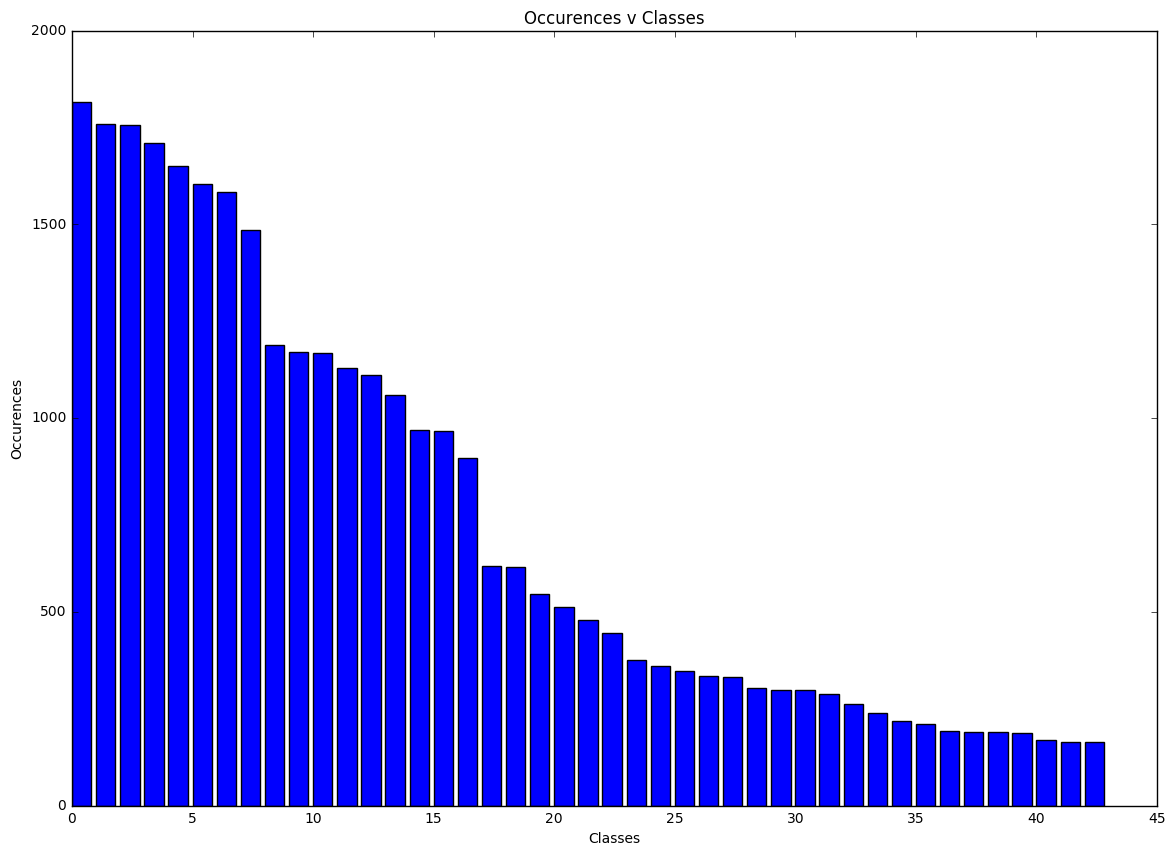

In [99]:
plt.figure(figsize = (14, 10))
plt.bar(range(43), height = data_pd_sorted['Occurance'])
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.title('Occurences v Classes')

In [100]:
def plot_class_occurence_random_sample(n_row, n_col, X, y):
    plt.figure(figsize = (8, 8))
    gs1 = gridspec.GridSpec(4, 4) #GridSpec(row, col)
    gs1.update(wspace = 0.01, hspace = 0.02) #spacing bw axes
    
    for i in range(n_row * n_col):
        ax1 = plt.subplot(gs1[i])
        rand_index = np.random.randint(0, len(y)) # pick a random index in labels

        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        occurence = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[rand_index]]['Occurance'].values[0]
        sign_name = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_train[rand_index]]['SignName'].values[0]
        plt.text(0, 0, "class: " + str(y_train[rand_index]) + "\noccurence: " + str(occurence) + "\nname: " + str(sign_name), 
                color = 'k', backgroundcolor = 'g')
        plt.imshow(X_train[rand_index])
        plt.axis('off')
    plt.show()

# <font color='green'>Occupancy Examples</font>

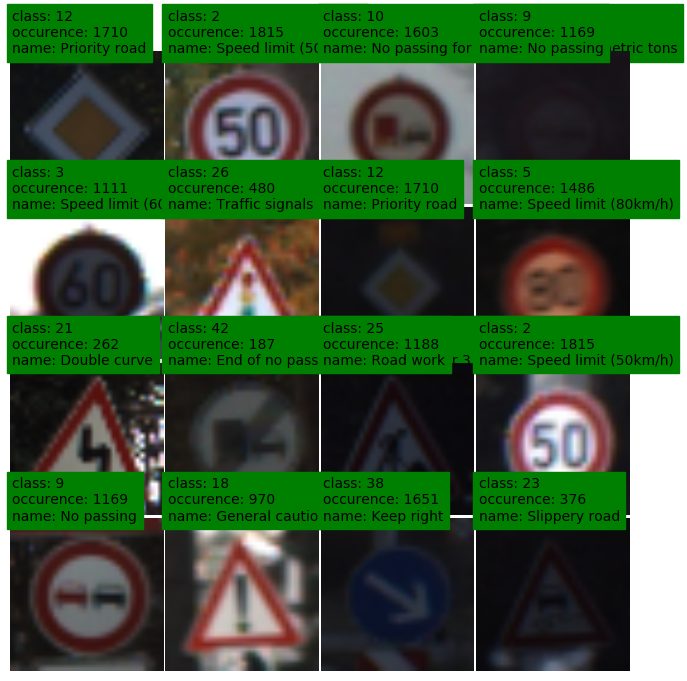

In [101]:
plot_class_occurence_random_sample(4, 4, X_train, y_train)


## Comments:

As you can see, there is a big difference in the abudance of each traffic sign's class. Some signs are heavily abundant, and some are sparse. We seek to level this out by taking the sparse classes, rotating their images, and creating more of them.

# Preprocessing:

# 1) Histogram Equalization

## Implementing Normal Equalization and Clahe Equalization:

In [102]:
rand_int = np.random.randint(0, len(y_train))
print('rand_int: ', rand_int)
# Change image from RGB to YUV

image1 = np.copy(X_train[rand_int])
image2 = np.copy(X_train[rand_int])
image3 = np.copy(X_train[rand_int])


# Normal Equalization
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2YUV)
Yimage2 = image2[:,:,0]
equalize_y2 = cv2.equalizeHist(Yimage2)
image2[:,:,0] = equalize_y2
image2RGB = cv2.cvtColor(image2, cv2.COLOR_YUV2RGB) # Back to RGB

# CLAHE Equalization
Yimage3 = image3[:,:,0]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
equalize_y3 = clahe.apply(Yimage3)
image3[:,:,0] = equalize_y3
image3RGB = cv2.cvtColor(image2, cv2.COLOR_YUV2RGB)

rand_int:  10721


### Plot Histograms to show effectiveness of histogram equalization


## <font color='red'>Add in later for histogram graph </font>

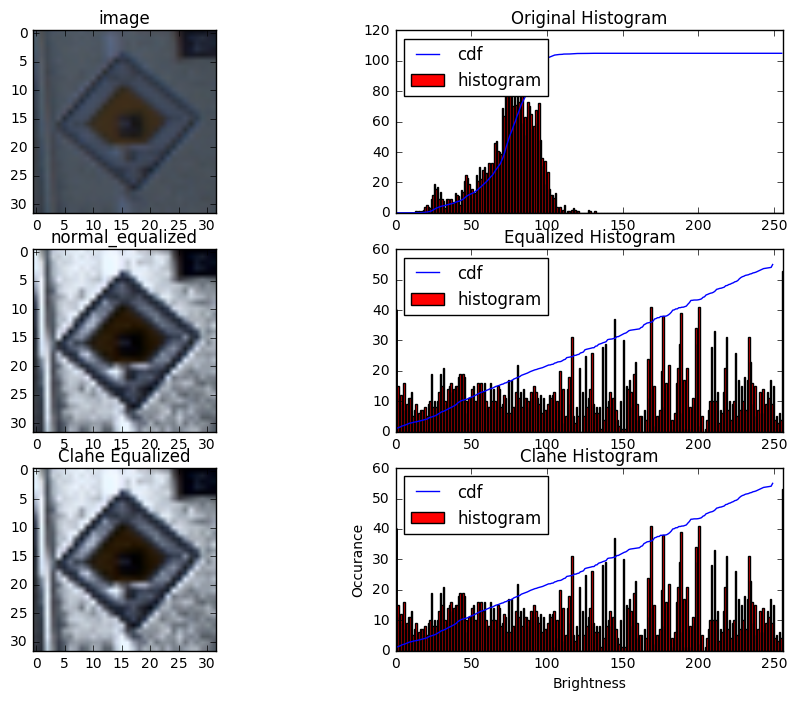

In [103]:
from helpers import normal_equalize
from helpers import histogram_equalize_data
from plotters import plot_histograms
image2TestRGB = normal_equalize(X_train[rand_int])

plot_histograms(image1, image2TestRGB, image3RGB)

### As we can see, the regular histogram equalization and the clahe equalization seem to both work.
In practice this reduced my error by ~1% on my validation set.

### Brightness Augmentation (not performed yet)

We seek to convert the original image from RGB to HSV (Hough, Saturation, Value). We isolate the V (brightness) and increase it by a random scaling factor with uniform distribution

Because at this point we have already performed max-min normalization, our values

#### We perform histogram equalization so we can make the brightness values more consistent within each image

# <font color='red'>Add in later for transform example</font>

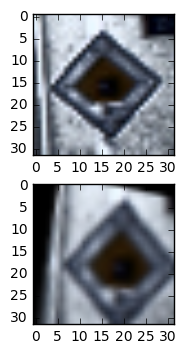

In [104]:
plt.imshow(image2TestRGB)
transformed = transform_image(image2TestRGB,20, 10, 5)
plt.subplot(211)
plt.imshow(image2TestRGB)
plt.subplot(212)
plt.imshow(transformed)
plt.show()

## Transform 100 images and evaluate

# <font color='red'>Add in later for transform graph</font>

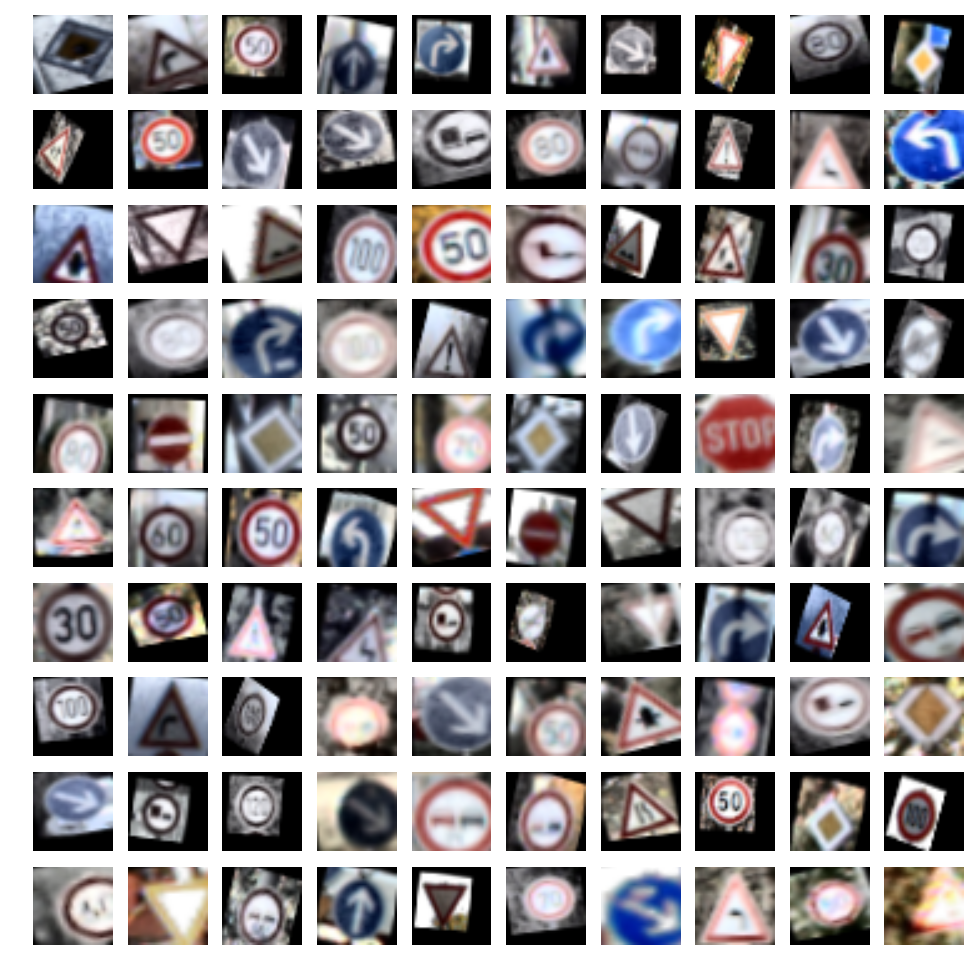

In [105]:
t_set = X_train[rand_int:rand_int + 100]

# histogram equalize first
t_set = histogram_equalize_data(t_set)
t_set = np.asarray(t_set, np.uint8)


gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace = 0.01, hspace = 0.02)
plt.figure(figsize = (12, 12))
for i in range(len(t_set)):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(t_set[i],20,10,5)

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Preprocessing - Implementation:

## Stage 0: Shuffle

In [106]:
# SHUFFLE LAST
X_train, y_train = shuffle(X_train, y_train)

## Stage 1: Histogram Equalization
#### Input: (batch, 32, 32, 3)  Output: (batch, 32, 32, 3)

In [107]:
X_train_equalized = histogram_equalize_data(X_train)
X_validation_equalized = histogram_equalize_data(X_validation)
X_test_equalized = histogram_equalize_data(X_test)

# Change types to uint8 for grayscaling
X_train_equalized = X_train_equalized.astype(np.uint8)
X_validation_equalized = X_validation_equalized.astype(np.uint8)
X_test_equalized = X_test_equalized.astype(np.uint8)

## Stage 2: Transform, Data Creation and Brightness Augmentation

Our goal is to generalize our model to an incoming test set. We ultimately want a training dataset where each class is equally represented. We do not know what the abundances of each sign class will be in our test set while we are training our model. We want our model to be able to classify any of the training images. As such we can perform the following procedures.

#### Step 1: 
* Gather a histogram about the abundances of each class in the training set
* Rotate, shear, transform, and copy each image in the training set

#### Step 2:
* Find the max abundance (max_abundance) of all the classes in the training set
* Find the classes that are below average abundance in the training set
* Rotate, shear, transform, and copy each of those images that are below average abundance and save to data_set_A
* Define a scaling factor C = max_abundance - class_abundance
* Rotate, shear, transform and copy those images C times and save to data_set_B
* Concatenate data_set_A with data_set_B
After this is performed we should ideally have a uniform distribution of class abundances, where each image in the set has been rotated, sheared, and transformed.
We perform Step 1 and Step 2 on the training data, but we only perform Step 1 on the test data because we do not know the abundances of our data when we test

After we perform this procedure our model will be able to generalize to any image equally

#### Input: X_train_equalized (3137, 32, 32, 3) Output: X_train_set

In [108]:
# First copy and transform all the images in X_train_equalized
# X_train_set_A = transform_image_data(X_train_equalized, ang_range = 10, shear_range = 30, trans_range = 5)

# # Without histogram equalization
# X_train_set_A = transform_image_data(X_train, ang_range = 10, shear_range = 10, trans_range = 5)

Dont transform and rotate validation data

In [109]:
# from helpers import copy_and_transform_dataset
# X_train_set_B, Y_train_set_B = copy_and_transform_dataset(x = [], y = [])
# X_train_set_A = X_train_set_A.astype(np.uint8)

# print('x_train_Set_B shape: ', X_train_set_B.shape)
# print('y_train_set_B shape: ', Y_train_set_B.shape)


# # # Add them together
# X_train_added = np.append(X_train_set_A, X_train_set_B, axis = 0) # dont forget to specify axis = 0
# y_train_added = np.append(y_train, Y_train_set_B, axis = 0)

# X_train_added = X_train_added.astype(np.uint8)
# print('X_train_added shape : ', X_train_added.dtype)
# print('y_train_added shape :', y_train_added.dtype)
# # y_train = y_train_added # if we want to do transformations on training data


In [110]:
# print('X_train_added shape: ', X_train_added.shape)
# print('y_train_added shape: ', y_train_added.shape)

## Stage 4,5: Grayscale + MaxMin Normalization on Train/ Validation set

In [111]:
from helpers import normalize_grayscale

# With no transformation
X_train_gray_data_manual = normalize_grayscale(X_train_equalized)
X_validation_gray_data_manual = normalize_grayscale(X_validation_equalized)
X_test_gray_data_manual = normalize_grayscale(X_test_equalized)

X_train = np.expand_dims(X_train_gray_data_manual, axis = 3)
X_validation = np.expand_dims(X_validation_gray_data_manual, axis = 3)
X_test = np.expand_dims(X_test_gray_data_manual, axis=3)

In [112]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_validation: ', X_validation.shape)
print('y_validation: ', y_validation.shape)
print('X_test: ', X_test.shape)
print('Y_test: ', y_test.shape)

X_train:  (31367, 32, 32, 1)
y_train:  (31367,)
X_validation:  (7842, 32, 32, 1)
y_validation:  (7842,)
X_test:  (12630, 32, 32, 1)
Y_test:  (12630,)


In [113]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_validation.shape[0] == y_validation.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

# ARCHITECTURE

In [114]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 53
BATCH_SIZE = 256

## Hyperparameter tuning:
Before I implemented histogram equalization I was able to achieve a low error withing 15 Epochs. After implementing histogram equalization I found that I was able to achieve better accuracy at ~98% with 40 epochs.

## Implement TrafficNet-5 Layer
### Input: (32, 32, 3) <- this may change if you grayscale

## Architecture:

My mindset the whole time was that I may be overfitting, and that the validation accuracy is not test accuracy, do I didn't want to be persuaded that my CNN was going to test well just because I hit 97% accuracy on a validation set, because overfitting may be the issue. Increasing epoch size to 40 -> 98%

I had to move the weights and biases out of TrafficNet in order to normalize them

In [115]:
mu = 0
sigma = 0.1
weights = {
        'wc1': tf.Variable(tf.truncated_normal([5,5,1,6], mean = mu, stddev = sigma), name="weights_wc1"),
        'wc2': tf.Variable(tf.truncated_normal([5,5,6,16], mean = mu, stddev = sigma), name="weights_wc2"),
        'wd1': tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma), name="weights_wd1"),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma), name="weights_wcd2"),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], mean = mu, stddev = sigma, name="weights_out"))
    }
biases = {
        'bc1': tf.Variable(tf.zeros([6]), name="biases_bc1"),
        'bc2': tf.Variable(tf.zeros([16]), name="biases_bc2"),
        'bd1': tf.Variable(tf.zeros([120]), name="biases_bd1"),
        'bd2': tf.Variable(tf.zeros([84]), name="biases_bd2"),
        'out': tf.Variable(tf.zeros([n_classes]), name="biases_out")
    }


remove biases from this

In [116]:
def TrafficNet(x, weights, biases, keep_prob_l1, keep_prob_l2, keep_prob_l3, keep_prob_l4):
    mu = 0
    sigma = 0.1
    # Prelayer analysis on input image
    
    print('PreLayer input shape: ', x.get_shape().as_list())
    assert(x.get_shape().as_list() == [None, 32, 32, 1])
    print('PreLayer shape verified!')
    
    # Layer 1: Convolutional. Input shape: [None, 32, 32, 3] Output shape:[None, 28, 28, 6]
    
    Layer_1 = tf.nn.conv2d(x, weights['wc1'], strides = [1,1,1,1], padding = 'VALID')
    Layer_1 = tf.nn.bias_add(Layer_1, biases['bc1'])
    print('Layer_1 shape: pre conv1', Layer_1.get_shape().as_list()) #14,14,6
    assert(Layer_1.get_shape().as_list() == [None, 28, 28, 6])
    
    # Activation: 
    Layer_1 = tf.nn.relu(Layer_1)
    
    # Dropout keep_prob = 0.5
    
    Layer_1 = tf.nn.dropout(Layer_1,  keep_prob_l1)

    # Pooling: Input shape: Input shape: [None, 28, 28, 6] Output shape: [None, 14, 14, 6]
    k_size_p1 = [1, 2, 2, 1]
    strides_p1 = [1, 2, 2, 1]
    padding_p1 = 'VALID'
    
    Layer_1 = tf.nn.max_pool(Layer_1, k_size_p1, strides_p1, padding_p1)
    print('Layer_1 after pool_1 shape: ', Layer_1.get_shape().as_list())
    assert(Layer_1.get_shape().as_list() == [None, 14, 14, 6])
    
    # Layer 2: Convolutional: Input shape: [None, 14, 14, 6] Output shape: [None, 10, 10, 16]
    Layer_2 = tf.nn.conv2d(Layer_1, weights['wc2'], strides = [1,1,1,1], padding = 'VALID') + biases['bc2']
    Layer_2 = tf.nn.bias_add(Layer_2, biases['bc2'])
    print('Layer_2 before pool_2 shape: ', Layer_2.get_shape().as_list())
    assert(Layer_2.get_shape().as_list() == [None, 10, 10, 16])    
    
    # Activation:
    
    Layer_2 = tf.nn.relu(Layer_2)
    
    # Dropout:
    
    Layer_2 = tf.nn.dropout(Layer_2,  keep_prob_l2)

    # Pooling: Input shape: [None, 10, 10, 16] Output shape: [None, 5, 5, 16]
    
    Layer_2 = tf.nn.max_pool(Layer_2, [1,2,2,1], [1,2,2,1], 'VALID')
    print('Layer_2 after pool_2 shape: ', Layer_2.get_shape().as_list())
    assert(Layer_2.get_shape().as_list() == [None, 5, 5, 16])
    
    # Flatten: Input shape: [None, 5, 5, 16] Output shape: [None, 1, 5*5*16]
    
    Flatten_1 = tf.reshape(Layer_2, [-1, 400])
    print('Flatten_1 shape: ', Flatten_1.get_shape().as_list())
    assert(Flatten_1.get_shape().as_list() == [None, 400])
    
    # Layer 3: Fully Connected: Input shape: [None, 1, 5*5*16] Output shape: [None, 120]
    
    Layer_3_FC1 = tf.add(tf.matmul(Flatten_1, weights['wd1']), biases['bd1'])
    print('Layer_3_FC1 : ',  Layer_3_FC1.get_shape().as_list())
    assert(Layer_3_FC1.get_shape().as_list() == [None, 120])
    
    # Activation: 
    
    Layer_3_FC1 = tf.nn.relu(Layer_3_FC1)
    
    # Dropout: keep_prob = 0.8
    
    Layer_3_FC1 = tf.nn.dropout(Layer_3_FC1,  keep_prob_l3)
    
    # TODO Layer 4: Fully Connected: Input shape: [None, 120] Output shape: [None, 84]
    
    Layer_4_FC2 = tf.add(tf.matmul(Layer_3_FC1, weights['wd2']), biases['bd2'])
    print('Layer_4_FC2: ', Layer_4_FC2.get_shape().as_list())
    assert(Layer_4_FC2.get_shape().as_list() == [None, 84])
    
    # Activation
    
    Layer_4_FC2 = tf.nn.relu(Layer_4_FC2)
    
    # TODO Dropout: keep_prob = 0.7
    # Fact: Had better validation set accuracy before dropout! was at 97.5 , but dropout prevents overfitting
    Layer_4_FC2 = tf.nn.dropout(Layer_4_FC2, keep_prob_l4)
    
    # Layer 5: Fully Connected (Logits): Input shape: [None, 84] Output_shape: [None, 43]
    
    Layer_5_FC3 = tf.add(tf.matmul(Layer_4_FC2, weights['out']), biases['out'])
    print('Layer_5_FC3: ', Layer_5_FC3.get_shape().as_list())
    assert(Layer_5_FC3.get_shape().as_list() == [None, n_classes])
    logits = Layer_5_FC3
    
    # Output: Logits shape: [None, 43]
    return logits

## Features and Labels
Train TrafficNet to classify Traffic-Sign data
x is a placeholder for a batch of input images, y is a placeholder for a batch of output labels

In [117]:
#  Create the graph variables
x = tf.placeholder(tf.float32, [None, 32, 32, 1]) #unpack tuple in case we convert to grayscale
y = tf.placeholder(tf.int32, [None])

keep_prob_l1 = tf.placeholder(tf.float32)
keep_prob_l2 = tf.placeholder(tf.float32)
keep_prob_l3 = tf.placeholder(tf.float32)
keep_prob_l4 = tf.placeholder(tf.float32)

test_type = tf.placeholder(tf.string)
one_hot_y = tf.one_hot(y, n_classes)

# Training Pipeline
Create a training pipeline that uses the model to classify Traffic Sign data

In [118]:
# Here we create the model parameters
rate = 0.001
β = 0.001

logits = TrafficNet(x, weights, biases, keep_prob_l1, keep_prob_l2, keep_prob_l3, keep_prob_l4)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) \
+ β*tf.nn.l2_loss(weights['wd1']) \
+ β*tf.nn.l2_loss(weights['wd2']) \
# + β*tf.nn.l2_loss(weights['out'])
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

PreLayer input shape:  [None, 32, 32, 1]
PreLayer shape verified!
Layer_1 shape: pre conv1 [None, 28, 28, 6]
Layer_1 after pool_1 shape:  [None, 14, 14, 6]
Layer_2 before pool_2 shape:  [None, 10, 10, 16]
Layer_2 after pool_2 shape:  [None, 5, 5, 16]
Flatten_1 shape:  [None, 400]
Layer_3_FC1 :  [None, 120]
Layer_4_FC2:  [None, 84]
Layer_5_FC3:  [None, 43]


# Model Evaluation
Evaluate loss and accuracy of the model for a given dataset

In [119]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #note: casting just changes the type
saver = tf.train.Saver()

labels_pred = logits
labels_pred_cls = tf.argmax(logits, 1)
def evaluate(X_data, y_data):
    
    
    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset: offset + BATCH_SIZE], y_data[offset: offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict = { x: batch_x, y: batch_y, 
                    keep_prob_l1: 1,
                    keep_prob_l2: 1,
                    keep_prob_l3: 1,
                    keep_prob_l4: 1
        })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Train the Model
Run the training data throug the training data pipeline to train the model
<ul>
<li>Before each epoch, shuffle the training set</li>
<li>After each epoch, measure the loss and accuracy of the validation set </li>
<li>Save the model after training</li>
</ul>

In [120]:
# Save data for plotting
EPOCHS_STORE = []
Accuracies = []
save_file = 'traffic-test-lala'

In [121]:
print(type(y_validation))
print(y_validation.shape)
print(y_validation.dtype)

<class 'numpy.ndarray'>
(7842,)
uint8


In [ ]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print('Training...')
    print()
    for i in range(EPOCHS):
        # Shuffle the training values before training
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x_train, batch_y_train = X_train[offset:end], y_train[offset: end]
            sess.run(training_operation, feed_dict = {x: batch_x_train, y: batch_y_train, 
                     keep_prob_l1: 0.9,
                     keep_prob_l2: 0.8,
                     keep_prob_l3: 0.7,
                     keep_prob_l4: 0.5
               
            })        
        validation_accuracy = evaluate(X_validation, y_validation) # create with sklearn 
        EPOCHS_STORE.append(i+1)
        Accuracies.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, save_file)
    print('Model saved in file: %s', save_file)

# Results of training:

ValueError: attempt to get argmax of an empty sequence

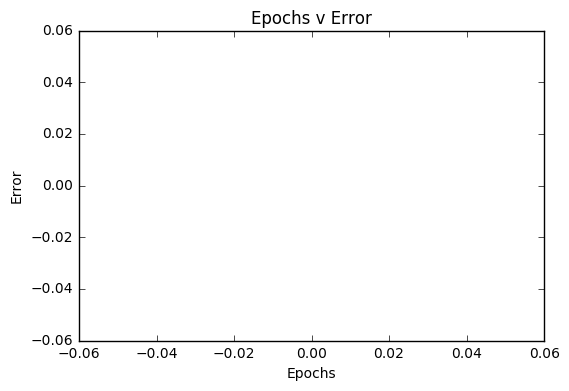

In [122]:
# print('EPOCHS: ', EPOCHS)
# print('ACCURACIES: ', len(Accuracies))

plt.title('Epochs v Error')
Error_scores = [1 - a for a in Accuracies]
plt.plot(EPOCHS_STORE, Error_scores)
plt.xlabel('Epochs')
plt.ylabel('Error')
max_idx = np.argmax(Accuracies)
plt.annotate('max accuracy: '+ str(Accuracies[max_idx] * 100) + '%', xy=(max_idx, Error_scores[max_idx]), xytext=(16, .18),
            arrowprops=dict(facecolor='black', shrink = 0.05))
plt.show()

## Analysis on Test Set
As you can see, we really start to get marginal differences after epoch 12. The error rate also oscillates, increasing and decreasing with each epoch.

In [24]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.929


Load the weights

# Analysis on new test images

In [ ]:
# ls new_signs/images/

In [65]:
import glob
import matplotlib.image as mpimg

new_images = []
new_image_labels = []
# Save images as jpg to reduce 3rd dimension from 4 to 3
for name in glob.glob('new_signs/images/*'):
    img = cv2.imread(name)
    cv2.imwrite(name[:-3] + 'jpg', img)

i = 0
# Resize jpg images
for idx, name in enumerate(glob.glob('new_signs/images/*.jpg')):
    new_image_labels.append(name[17:-4])
#     print(str(idx) + ' | name: ', name[17:-4])
    img = mpimg.imread(name)
    img = cv2.resize(img, (32, 32), cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_images.append(img)
#     plt.imshow(img)

#### grab a subset of the images to map them

In [66]:
cache_unique_class_index_test = {}
for i in range(len(y_test)):
    row = data_pd_sorted.loc[data_pd_sorted['ClassId'] == y_test[i]]
    ClassId = row['ClassId'].values[0]
    ClassId = str(ClassId)
    if not ClassId in cache_unique_class_index_test:
        cache_unique_class_index_test[ClassId] = [i, row['SignName'].values[0]]

In [67]:
# cache_unique_class_index_test
# plt.imshow(X_test[243])

In [68]:
def process_new_image_and_reduce_dims(image_data):
    image_data = np.asarray(image_data, dtype=np.uint8)
    images_equalized = histogram_equalize_data(image_data)
    images_equalized = np.asarray(images_equalized, dtype = np.uint8)
    images_gray = normalize_grayscale(images_equalized)
    images_gray = np.expand_dims(images_gray, axis = 3)
    images_gray = np.asarray(images_gray, dtype=np.float32)
    return images_gray

def process_new_image(image_data):
    image_data = np.asarray(image_data, dtype=np.uint8)
    images_equalized = histogram_equalize_data(image_data)
    images_equalized = np.asarray(images_equalized, dtype = np.uint8)
    return normalize_grayscale(images_equalized)
    


In [69]:
newdata = process_new_image(new_images)
# new_image_labels
new_images = np.asarray(new_images, dtype=np.uint8)


newdata_expand = process_new_image_and_reduce_dims(new_images)

In [70]:
softmax_logits = tf.nn.softmax(logits)
top_3 = tf.nn.top_k(softmax_logits, k=3)

with tf.Session() as sess:
    saver.restore(sess, save_file)
    my_softmax_logits = sess.run(softmax_logits, feed_dict = {x : newdata_expand, keep_prob_l1: 0.9,
                     keep_prob_l2: 0.8,
                     keep_prob_l3: 0.7,
                     keep_prob_l4: 0.5 })
    top_3_pred = sess.run(top_3, feed_dict = {x : newdata_expand, keep_prob_l1: 0.9,
                     keep_prob_l2: 0.8,
                     keep_prob_l3: 0.7,
                     keep_prob_l4: 0.5 })    

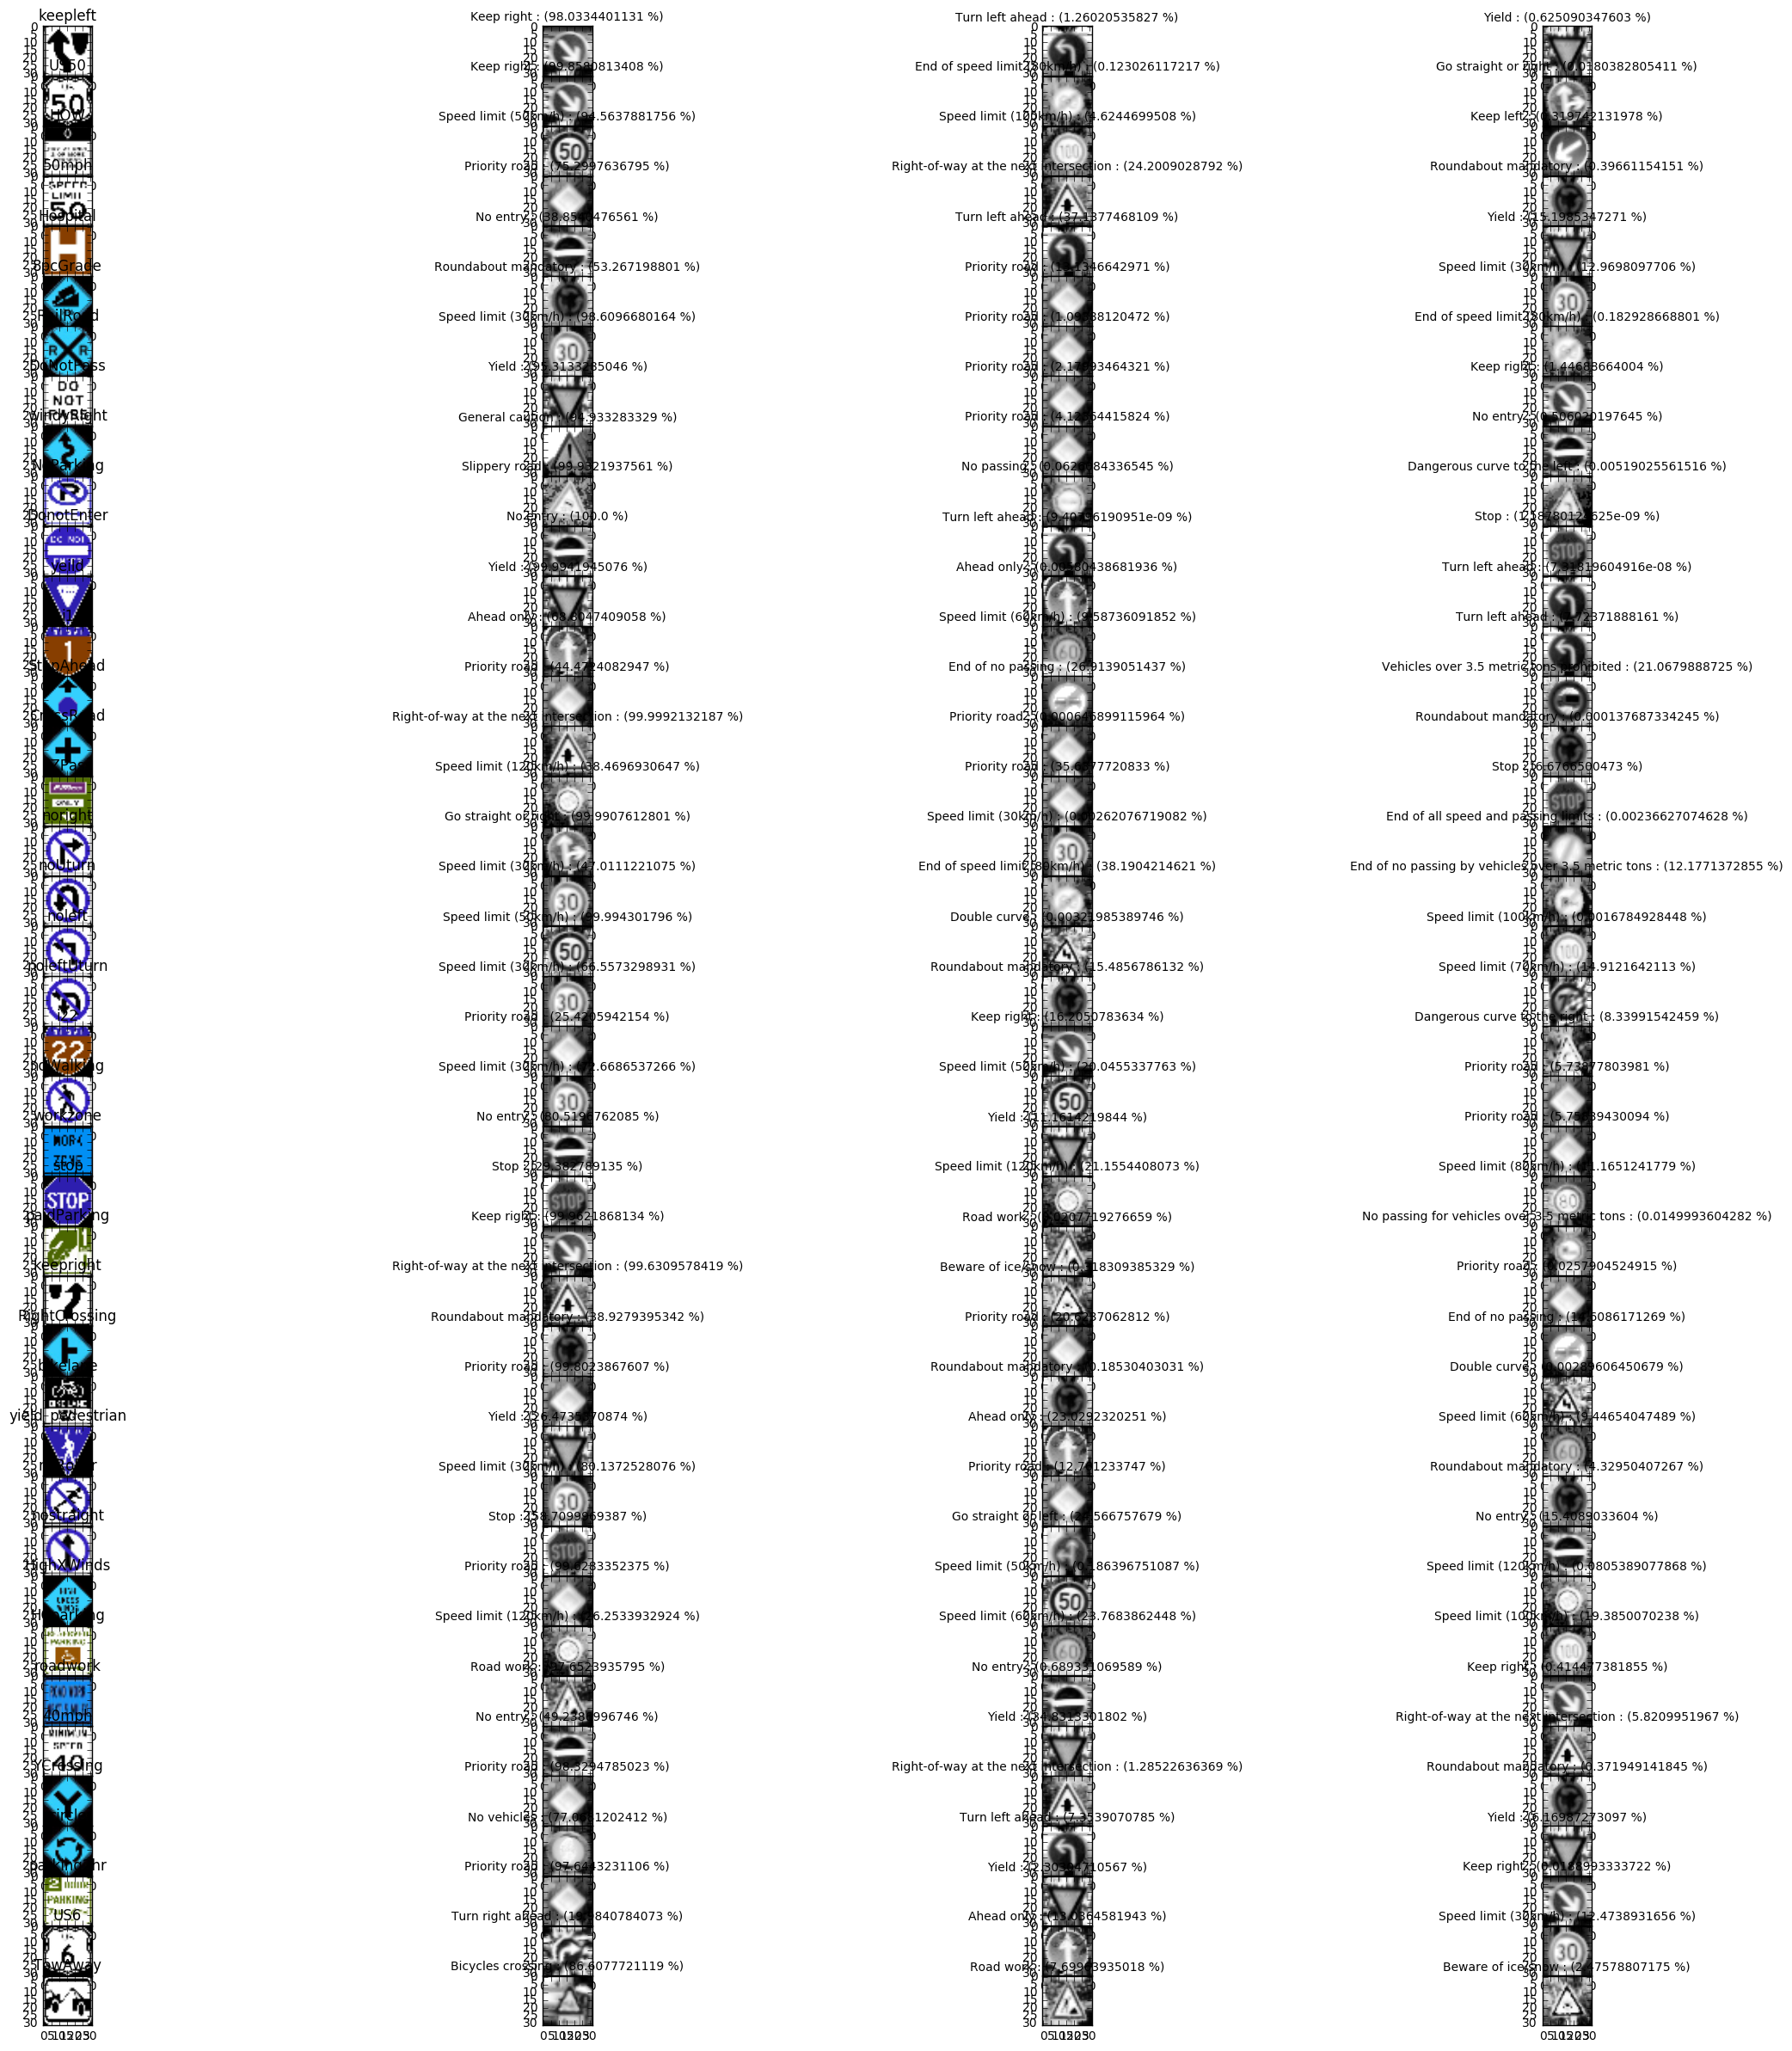

In [71]:
k_values = top_3_pred[0]
k_indices = top_3_pred[1]

fig, axs = plt.subplots(40,4, figsize=(30, 30))
fig.subplots_adjust(hspace = .01, wspace=0)
axs = axs.ravel()

# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

#     print('newdata: ', new_images.shape)
# print('new_image_labels: ', len(new_image_labels))

# Can change image back to original images not preprocessed
for idx, image in enumerate(new_images):
#     print('idx: ', idx)
#         print('image: ', image.shape)

    axs[4 * idx].imshow(image)
    axs[4 * idx].set_title(new_image_labels[idx])

    # 2
    ind_1 = k_indices[idx][0]
    sc_1 = k_values[idx][0]
    guess_1_row = data_pd_sorted.loc[data_pd_sorted['ClassId'] == ind_1]
#         print('guess_1_row: ', guess_1_row)
    guess_1_name = guess_1_row['SignName'].values[0]
#     print('guess_1_name: ', guess_1_name)
    guess_1_perc = str(sc_1 * 100) + ' %'
#     print('guess_1_perc: ', guess_1_perc)
    guess_1_pic_index = cache_unique_class_index_test[str(ind_1)][0] #maybe switch to new train data
#     print('guess_1_pic_index: ', guess_1_pic_index)
    guess_1_img = X_test[guess_1_pic_index]
    guess_1_img = np.squeeze(guess_1_img, axis = 2)
    axs[4 * idx + 1].imshow(guess_1_img, cmap="gray")
    axs[4 * idx + 1].set_title(str(guess_1_name) + ' : ({})'.format(guess_1_perc), fontsize="10")

    # 3
    ind_2 = k_indices[idx][1]
    sc_2 = k_values[idx][1]
    guess_2_row = data_pd_sorted.loc[data_pd_sorted['ClassId'] == ind_2]
#         print('guess_2_row: ', guess_2_row)
    guess_2_name = guess_2_row['SignName'].values[0]
#     print('guess_2_name: ', guess_2_name)
    guess_2_perc = str(sc_2 * 100) + ' %'
#     print('guess_2_perc: ', guess_2_perc)
    guess_2_pic_index = cache_unique_class_index_test[str(ind_2)][0] #maybe switch to new train data
#     print('guess_2_pic_index: ', guess_2_pic_index)
    guess_2_img = X_test[guess_2_pic_index]
    guess_2_img = np.squeeze(guess_2_img, axis = 2)
    axs[4 * idx + 2].imshow(guess_2_img, cmap="gray")
    axs[4 * idx + 2].set_title(str(guess_2_name) + ' : ({})'.format(guess_2_perc), fontsize="10")
    
    # 4
    ind_3 = k_indices[idx][2]
    sc_3 = k_values[idx][2]
    guess_3_row = data_pd_sorted.loc[data_pd_sorted['ClassId'] == ind_3]
    guess_3_name = guess_3_row['SignName'].values[0]
#     print('guess_3_name: ', guess_3_name)
    guess_3_perc = str(sc_3 * 100) + ' %'
#     print('guess_3_perc: ', guess_3_perc)
    guess_3_pic_index = cache_unique_class_index_test[str(ind_3)][0] #maybe switch to new train data
#     print('guess_3_pic_index: ', guess_3_pic_index)
    guess_3_img = X_test[guess_3_pic_index]
    guess_3_img = np.squeeze(guess_3_img, axis = 2)
    axs[4 * idx + 3].imshow(guess_3_img, cmap="gray")
    axs[4 * idx + 3].set_title(str(guess_3_name) + ' : ({})'.format(guess_3_perc), fontsize="10")

    
    

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(X_test_new, y_test_new)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

# Test model

### EXPLANATIONS 
# Question 1:
_Describe how you preprocessed the data. Why did you choose that technique?_

### Answer:
My first conclusion was that I needed to perform histogram equalization before I grayscale + normalize because grayscale + normalization results in data loss. Even though it is slower to perform equalization over three layers, I didn't want to lose information about the data set.

#### Histogram Equalization + Brightness augmentation order:
I added brightness augmentation after histogram equalization. After we equalize the pixel distribution it appears "more normal". Then we add the randomness factor of brightness augmentation by increasing random brightness values to random parts of the image. This introduces a randomness factor which will prevent our model from overfitting because the model is being trained on images with random brightness values. If we performed brightness augmentation first followed by histogram equalization we would end up with a roughly "normalized" contrast distribution, but it would be normalized not from the original data, but from the original data + brightness augmentation. This would cause our normalization curve to shift to a false location.

## Steps: 
### 1) Histogram Equalization:
I applied a contrast limited adaptive histogram equalization to prevent overamplification of noise that adaptive histogram equalization can give rise to, (loss of information due to over brightness). This noise-amplification may occur if the histogram is not confined to a particular region in the image. 

CLAHE limits the amplification by clipping the histogram at a predifined value before computing the Cumulative Distribution Function, limiting the slope of the CDF -> limits the transform function.

I utilized OpenCV's clahe class structure with a clipLimit = , and a tileGridSize = 

### 2) Affine transformation and data creation
When we transform image data we won't know which dataset will be lacking in our test or validation set so we simply create additional data for every data point in the training set.

#### Rotate, Transform, Jitter: Create Additional Data

As you can see in the histogram we have uneven traffic sign abundances. We seek to generalize our data for any sign in the data set, and to not specifically train our model any specific traffic sign. To do this we wil Rotate, Jitter, Transform and create additional traffic sign models. These affine transformations will be performed in OpenCV.

One way to create more data is to change the camera angle of the sign and apply affine warping with OpenCV and submit that as another data point.
We apply a random uniform distribution constant to our warping parameters in order to maintain randomness and attempt to give equal probability to the degree of each transformation.

When we transform image data we won't know which dataset will be lacking in our test or validation set so we simply create additional data for every data point in the training set.

When tested, this method proved to give me 2% less accuracy then when I didn't transform. This could be due to flattening out the histogram so there was a uniform distribution of each sign's abundance. In reality, traffic signs are not uniformally distributed among the streets, so we shouldn't have a uniform set when training our model.

### Brightness Augmentation (not performed yet)

### 3) Brightness Augmentation:
I chose to convert RGB to YUV. Y = Luma (Brightness). This allows me to only adjust the luminance without distorting the color information. I chose to do this before grayscaling because grayscaling causes me to lose information by averaging the channels and converging them, (and I hope the RGB2YUV conversion doesn't). 

Grayscaling averages all the color channels and converges them to one channel while YUV maintains the same depth. Using just Y (luma) is different than using the grayscaled values because grayscaled values are affected by the colors, (flattened) whereas YUV allows us the maintain the colors and only augment the luminance (Y). For this same reason I perform Histogram Equalization only on the Y value.

We seek to convert the original image from RGB to HSV (Hough, Saturation, Value). We isolate the V (brightness) and increase it by a random scaling factor with uniform distribution

Because at this point we have already performed max-min normalization, our values

We seek to convert the original image from RGB to HSV (Hough, Saturation, Value). We isolate the V (brightness) and increase it by a random scaling factor with uniform distribution

Because at this point we have already performed max-min normalization, our values

#### We perform histogram equalization so we can make the brightness values more consistent within each image

### 4) Grayscaling:
First I grayscaled my data so that I could perform min-max scaling. I read online that Yan Le-Cun said having color did not increase performance that much so I decided to grayscale all the images.
Next came the normalization technique:
### 5) Normalization:
I chose to implement min-max scaling because it scaled my images from [0, 255] to a range [0, 1]. This is great for images specifically because other methods like mean variance normalization can create negative values which will then get dropped after my activation function. I didn't want to lose data and I still wanted normalized values.
<ul>Initially I used sklearn's preprocessing library, specifically the MinMax_Scaler function to normalize my data. I then implemented my own min-max scaling function and started testing which one gave me a better accuracy on the validation set. I found that with sklearns library I got 96.5% accuracy. With my manual function I tweaked the parameters as follows:
<li>a = 0.1, b = 0.9. accuracy = 92.4%</li>
<li>a = 0.05, b = 0.95 accuracy = 96.8 (at this point I chose to keep this method)</li>
</ul>

## Comments:
As it turns out I performed much much better on my validation training set when I did not augment or create additional data. When augmenting I was getting around ~92% accuracy on my validation set, when I just used the data given and did not transform, rotate, or shear it I received ~99% accuracy on my validation set. I don't know what my test accuracy would have been if I used the augmented data but I assume it would not have been as high.

This may be due to the augmentation itself. When transforming and shearing the images I replace what was image pixels with black pixels, those black pixels can disrupt my dataset because I do not expect to see such black pixels in the test and validation set

Because I have two normalization techniques, maybe that actually hurts my testing output. 

# Question 2
Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?

Answer: 
Run the training data throug the training data pipeline to train the model
<ul>
<li>Before each epoch, shuffle the training set</li>
<li>After each epoch, measure the loss and accuracy of the validation set </li>
<li>Save the model after training</li>
</ul>

# Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


## Architecture:

 #### Layer 1: Convolutional. Input shape: [None, 32, 32, 3] Output shape:[None, 28, 28, 6]
  
 #### Activation: 
    
 #### Pooling: Input shape: Input shape: [None, 28, 28, 6] Output shape: [None, 14, 14, 6]
    
 #### Layer 2: Convolutional: Input shape: [None, 14, 14, 6] Output shape: [None, 10, 10, 16]
    
 #### Activation:
    
 #### Pooling: Input shape: [None, 10, 10, 16] Output shape: [None, 5, 5, 16]
    
 #### Flatten: Input shape: [None, 5, 5, 16] Output shape: [None, 1, 5*5*16]
    
 #### Layer 3: Fully Connected: Input shape: [None, 1, 5*5*16] Output shape: [None, 120]
    
 #### Activation: 
 
 #### TODO : Dropout
    
 #### Layer 4: Fully Connected: Input shape: [None, 120] Output shape: [None, 84]
    
 #### Activation
    
 #### Layer 5: Fully Connected (Logits): Input shape: [None, 84] Output_shape: [None, 43]
    
 #### Output: Logits shape: [None, 43]

## Explanation:
### Dropout:
At first, I only implemented dropout on the fully connected layers and ignored the convolutional layers because they have few parameters. After some testing I increased my validation accuracy by around 1.5% with this method. At first I thought that because we are averaging the gradients in our convolutional layers that performing dropout will not prevent overfitting because we have already interconnected our feature maps by averaging the gradients over their spatial extent. So I just thought it would slow down training.

Then after reading [1] I noticed that they claimed an additional performance of 3.05% to 2.55% by adding dropout in the convolutional layers. My original assumption of preventing dropout in convolutional layers due to their parametric sparsity proved to be incorrect. Dropout in convolutional layers helps because it provides noisy inputs for the higher fully connected layes - preventing them from overfitting. I used keep_prob = 0.7 for the convolutional layers and 0.5 for the fully connected layers.

<ul>First stage: 
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.8</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.667</li>
<li>Validation Accuracy = 97% (may be overfitting)</li>
</ul>
<ul>Second stage:
<li>Dropout in Layer_1_Conv: keep_prob = 0.5</li>
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.8</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.667</li>
<li>Validation Accuracy = 96.4 (Dropped 0.6%)</li>
<li>Although my validation accuracy dropped 0.6% by implementing dropout in my first layer, it didn't drop enough to give me a poor validation accuracy and it will likely prevent overfitting.</li>
</ul>

<ul>Third stage:
<li>Dropout in Layer_1_Conv: keep_prob = 0.9</li>
<li>Dropout in Layer_2_Conv: keep_prob = 0.8</li>
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.7</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.5</li>
<li>Validation Accuracy = 96.4 (Dropped 0.6%)</li>
<li>Although my validation accuracy dropped 0.6% by implementing dropout in my first layer, it didn't drop enough to give me a poor validation accuracy and it will likely prevent overfitting.</li>
</ul>

<ul>Fourth stage:
<li>After I took out all the other dropout's and just left Dropout in Layer_4 at 0.5 I get validation accuracy of 94.3% in 10 epochs but 98.3% in 50 epochs</li>
<li>Dropout in Layer_1_Conv: keep_prob = 0.9</li>
<li>Dropout in Layer_2_Conv: keep_prob = 0.8</li>
<li>Dropout in Layer_3_FullyConnected_1: Keep_prob = 0.7</li>
<li>Dropout in Layer_4_FullyConnected_2: keep_prob = 0.5</li>
</ul>

My mindset the whole time was that I may be overfitting, and that the validation accuracy is not test accuracy, do I didn't want to be persuaded that my CNN was going to test well just because I hit 97% accuracy on a validation set, because overfitting may be the issue. Increasing epoch size to 40 -> 98%

**Answer:**

# Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


As you can see from the graph above, when we use 145 Epochs and a batch size of 256 we achieved ~99% accuracy on validation data. I increased my batch size from 128 to 256 because I have a larger GPU.

## Apply L2 Regularization
Apply L2Reg only on the weights, not the biases.
<ul>
<li>At first I implemented L2 Regularization on all the weights giving me a validation set accuracy of 97%</li> 
<li>Then I implemented it only on the fully connected layers, leading to a validation set accuracy of 97.1%, but this could just be to better starting weight initialization values</li>
<li>After testing L2 Regularization only on the fully connected layers I received a validation set accuracy of 97.5% so I kept this method</li>
<li>After testing L2 Regularization on the convolutional layers as well it seems that there is not much improvement because normalizing the fully connected layers retroactively normalizes the convolutional layers as well</li>
</ul>

In [ ]:
# print('EPOCHS: ', EPOCHS)
# print('ACCURACIES: ', len(Accuracies))

plt.title('Epochs v Error')
Error_scores = [1 - a for a in Accuracies]
plt.plot(EPOCHS_STORE, Error_scores)
plt.xlabel('Epochs')
plt.ylabel('Error')
max_idx = np.argmax(Accuracies)
plt.annotate('max accuracy: '+ str(Accuracies[max_idx] * 100) + '%', xy=(max_idx, Error_scores[max_idx]), xytext=(16, .18),
            arrowprops=dict(facecolor='black', shrink = 0.05))
plt.show()

## Analysis:
As you can see, we really start to get marginal differences after epoch 12. The error rate also oscillates, increasing and decreasing with each epoch.
At first I was using ~40 Epochs. Then I was using ~140 epochs and I noticed that I was oscillating between 98.7% and 99%. So I decided to trim it down to ~80 epochs where I knew I would be about 98%. This was I prevent overfitting

### Final Test Accuracy: 93.7%

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.